
Linear Regression Model:
RMSE: 1.6880694911329877, MAE: 0.9432271009469612, MAPE: 0.006084051219316342, Accuracy: 0.8282685512367491, Precision: 0.8607594936708861, Confusion Matrix:
[[560  99]
 [144 612]], Recall: 0.8095238095238095, F1 Score: 0.834355828220859

SVR Model:
RMSE: 139.76497837705972, MAE: 80.8494314698498, MAPE: 0.5135323618594273, Accuracy: 0.9992932862190813, Precision: 1.0, Confusion Matrix:
[[738   0]
 [  1 676]], Recall: 0.9985228951255539, F1 Score: 0.999260901699926

Random Forest Model:
RMSE: 2.2696019969365957, MAE: 1.2959525326831525, MAPE: 0.008225147954228209, Accuracy: 0.8600706713780919, Precision: 0.8626292466765141, Confusion Matrix:
[[633  93]
 [105 584]], Recall: 0.8476052249637155, F1 Score: 0.8550512445095169

Gradient Boosting Model:
RMSE: 2.685918356233534, MAE: 1.69115479259762, MAPE: 0.011694869673820272, Accuracy: 0.8989399293286219, Precision: 0.890961262553802, Confusion Matrix:
[[651  76]
 [ 67 621]], Recall: 0.9026162790697675, F1 Score: 0.

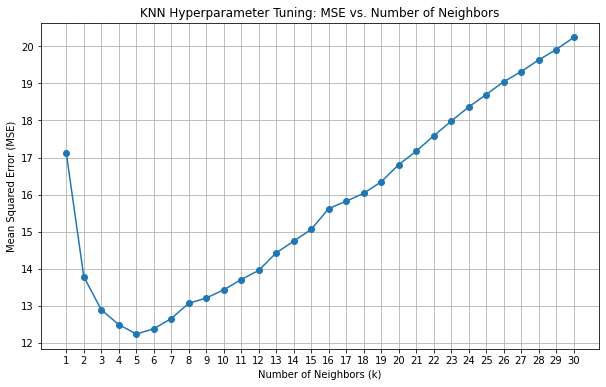

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('SBIN.csv')

# Data preprocessing
df.drop(['Date', 'Adj Close'], axis=1, inplace=True)  # Drop irrelevant columns

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Calculate VWAP
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

# Select features including VWAP and target variable
X = df[['Open', 'High', 'Low', 'Volume', 'VWAP']]
y = df['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to train and evaluate models
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, params=None):
    if params:
        model = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    accuracy = accuracy_score(y_test > predictions, y_test > predictions.round())
    precision = precision_score(y_test > predictions, y_test > predictions.round())
    confusion = confusion_matrix(y_test > predictions, y_test > predictions.round())
    recall = recall_score(y_test > predictions, y_test > predictions.round())
    f1 = f1_score(y_test > predictions, y_test > predictions.round())

    # Print the evaluation metrics
    print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, Accuracy: {accuracy}, Precision: {precision}, Confusion Matrix:\n{confusion}, Recall: {recall}, F1 Score: {f1}")

    return model

# Define models and their hyperparameters
models_params = {
    'Linear Regression': (LinearRegression(), None),
    'SVR': (SVR(), {'C': [0.1, 1], 'epsilon': [0.01, 0.1, 0.5], 'kernel': ['sigmoid']}),
    'Random Forest': (RandomForestRegressor(), None),
    'Gradient Boosting': (GradientBoostingRegressor(), None),
    'XGBoost': (xgb.XGBRegressor(), None),
    'AdaBoost': (AdaBoostRegressor(), None),
    'Decision Tree': (DecisionTreeRegressor(), None),
    'KNeighbors': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 9, 11, 15, 20, 23, 25, 30, 60, 70, 150]})
}

# Train and evaluate all models
for name, (model, params) in models_params.items():
    print(f"\n{name} Model:")
    train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, params)

# KNN Hyperparameter Tuning
def knn_hyperparameter_tuning(X_train, y_train):
    k_values = range(1, 31)  # Example range for k
    mse_values = []
    
    for k in k_values:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        mse = -cross_val_score(knn_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
        mse_values.append(mse)
    
    return k_values, mse_values

# Perform KNN Hyperparameter Tuning
k_values, mse_values = knn_hyperparameter_tuning(X_train_scaled, y_train)

# Plotting the results of KNN Hyperparameter Tuning
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o', linestyle='-')
plt.title('KNN Hyperparameter Tuning: MSE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(k_values)  # Show all k values on x-axis
plt.grid()
plt.show()
